In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("house_price_prediction.csv")

In [3]:
df.columns

Index(['date', 'price', 'bedrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'sqft_above', 'sqft_basement',
       'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17210 entries, 0 to 17209
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           17210 non-null  object 
 1   price          17210 non-null  int64  
 2   bedrooms       17210 non-null  int64  
 3   sqft_living    17210 non-null  int64  
 4   sqft_lot       17210 non-null  int64  
 5   floors         17210 non-null  float64
 6   waterfront     17210 non-null  int64  
 7   condition      17210 non-null  int64  
 8   grade          17210 non-null  int64  
 9   sqft_above     17210 non-null  int64  
 10  sqft_basement  17210 non-null  int64  
 11  yr_built       17210 non-null  int64  
 12  yr_renovated   17210 non-null  int64  
 13  zipcode        17210 non-null  int64  
 14  lat            17210 non-null  float64
 15  long           17210 non-null  float64
 16  sqft_living15  17210 non-null  int64  
 17  sqft_lot15     17210 non-null  int64  
dtypes: flo

In [5]:
skewnessList = df.drop('date',axis=1).skew()

In [6]:
skewnessList

price             3.821753
bedrooms          2.400169
sqft_living       1.472594
sqft_lot         13.627634
floors            0.614256
waterfront       10.992823
condition         1.062413
grade             0.797259
sqft_above        1.416897
sqft_basement     1.597025
yr_built         -0.482446
yr_renovated      4.552460
zipcode           0.405812
lat              -0.479820
long              0.874497
sqft_living15     1.110448
sqft_lot15        8.972974
dtype: float64

In [7]:
l = [k for k,v in zip(skewnessList.index,skewnessList) if v>2 or v<-2]
l

['price', 'bedrooms', 'sqft_lot', 'waterfront', 'yr_renovated', 'sqft_lot15']

In [8]:
df.drop('date',axis=1).kurtosis()

price             29.659426
bedrooms          61.829909
sqft_living        5.276713
sqft_lot         303.024513
floors            -0.477723
waterfront       118.855969
condition          0.498857
grade              1.166327
sqft_above         3.095529
sqft_basement      2.943596
yr_built          -0.650289
yr_renovated      18.728704
zipcode           -0.854362
lat               -0.694981
long               1.046694
sqft_living15      1.608948
sqft_lot15       126.789379
dtype: float64

In [9]:
#Power Transformation
df_log = df.copy()

In [10]:
df_log[l] = np.log(df_log[l]+1)

<Axes: >

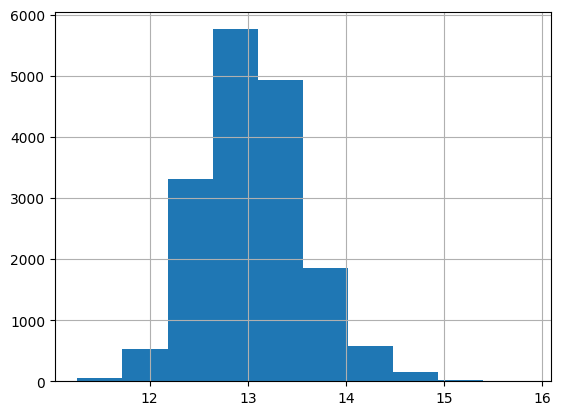

In [11]:
df_log['price'].hist() #After

<Axes: >

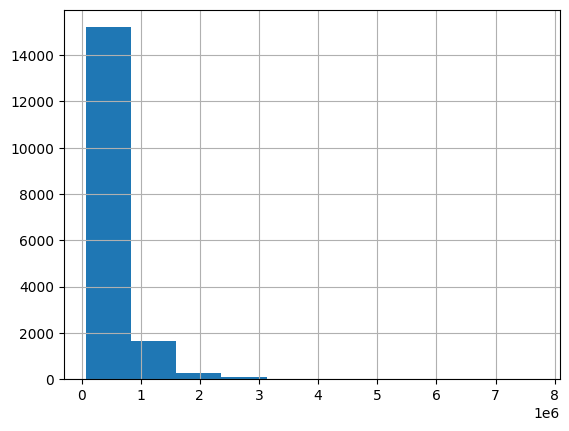

In [12]:
df['price'].hist() #Before

In [13]:
#Box-Cox
from sklearn.preprocessing import PowerTransformer
df_boxcox = df.copy()
df_boxcox[[l[0],l[2]]] = PowerTransformer(method='box-cox').fit_transform(df_boxcox[[l[0],l[2]]])

In [14]:
df_boxcox['price'].skew()

-0.012453164251062047

<Axes: >

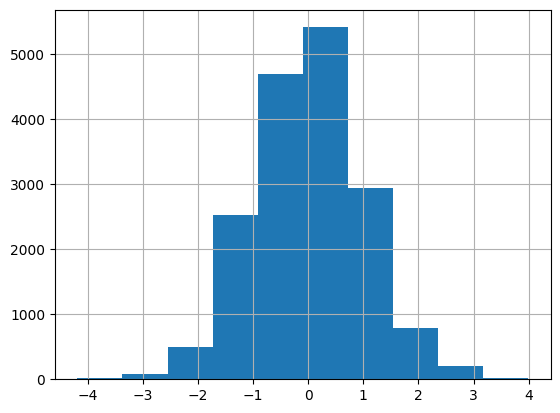

In [15]:
df_boxcox['price'].hist()

In [16]:
#Feature Engineering
df_log['date'] = pd.to_datetime(df_log['date'], format='mixed', dayfirst=False)

In [17]:
df_log['date'].dtypes

dtype('<M8[ns]')

In [18]:
df_log['house_age'] = df_log['date'].dt.year - df_log['yr_built']

In [19]:
df_log['house_age'].describe()

count    17210.000000
mean        43.030854
std         29.376780
min         -1.000000
25%         17.000000
50%         39.000000
75%         63.000000
max        115.000000
Name: house_age, dtype: float64

In [20]:
# create another feature
df_log['year_sell'] = df_log['date'].dt.year
df_log.drop(['date'], axis=1, inplace=True)

In [21]:
x = df_log.drop(['price'], axis=1)
y = df_log.loc[:,'price']

In [22]:
x.shape,y.shape

((17210, 18), (17210,))

In [23]:
x.columns

Index(['bedrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'house_age', 'year_sell'],
      dtype='object')

In [24]:
#PCA
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=117,test_size=0.3)

In [25]:
from sklearn.decomposition import PCA
pcaModel = PCA(n_components=0.95,random_state=117)

In [26]:
pcaModel.fit(x_train.drop('date',axis=1))
x_train_pca = pcaModel.transform(x_train)
x_test_pca = pcaModel.transform(x_test)
x_train_pca = pd.DataFrame(x_train_pca,index = x_train.index)
x_test_pca = pd.DataFrame(x_test_pca,index = x_test.index)
x_train_pca.shape , x_test_pca.shape

KeyError: "['date'] not found in axis"

In [ ]:
#LASSO
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(Lasso(alpha=0.01, random_state=7),
                      threshold = "0.25*mean")
sfm.fit(x,y)
print(sfm.get_feature_names_out())
trans_x = pd.DataFrame(sfm.transform(x),
                       columns = sfm.get_feature_names_out())
trans_x.shape

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(trans_x,y,
                                                 test_size=0.3,
                                                 random_state=7)

In [ ]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

In [ ]:
#Ridge
from sklearn.linear_model import LinearRegression,Lasso, \
Ridge, ElasticNet, SGDRegressor
from sklearn.metrics import mean_absolute_error,\
mean_squared_error, r2_score

In [ ]:
model_list = [LinearRegression(),Lasso(alpha=0.01,random_state=7),
              Ridge(random_state=7), ElasticNet(random_state=7),
              SGDRegressor(max_iter=100, random_state=7)]

In [ ]:
def evalModel(model, x_train,x_test,y_train,y_test):
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    mae = mean_absolute_error( y_test, y_pred)
    mse = mean_squared_error( y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(model.__class__ )
    print("MAE:",mae,"MSE:",mse,"R2:",r2,"\n")
    return mae,mse,r2

In [ ]:
for model in model_list:
    evalModel(model, x_train,x_test,y_train,y_test)

In [ ]:
#GRID SEARCH
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid={
    "alpha" : [0.09 , 0.19, 0.15 ],
    "max_iter" : [10, 20, 25]
}

In [ ]:
gs = GridSearchCV(Ridge(random_state=117),param_grid,cv=2,verbose=2)

In [ ]:
gs.fit(x_train,y_train)

In [ ]:
gs.best_score_

In [ ]:
gs.best_params_